# Multi-agent CoinGame solver using actor-critic (AC) agents with eQMARL coupling

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

import eqmarl
import matplotlib.pyplot as plt
import gymnasium as gym
from tensorflow import keras
import tensorflow as tf

In [32]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [33]:
# Quantum actor.
n_layers = 5
n_actions = 4 # CoinGame2 has 4 actions (north/south/east/west)
n_agents = 2
model_actor = eqmarl.generate_model_CoinGame2_actor_quantum_partite(
    n_agents=n_agents,
    n_layers=n_layers,
    # squash_activation='arctan',
    name='actor-quantum-eqmarl',
    )


# optimizer_actor = keras.optimizers.Adam(learning_rate=0.1)
optimizer_actor = [
    tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True),
    tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True),
    tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True),
]

model_actor.build((None, n_agents, 36))
model_actor.summary()

Model: "actor-quantum-eqmarl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 2, 4, 3)          0         
 l)                                                              
                                                                 
 HybridPartiteVariationalEnc  (None, 16)               264       
 odingPQC (HybridPartiteVari                                     
 ationalEncodingPQC)                                             
                                                                 
 observables-policy (Sequent  (None, 16)               16        
 ial)                                                            
                                                                 
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Classical critic.
model_critic = eqmarl.generate_model_critic_classical(
    units=[128, 64, 32],
    name=f"critic-classical",
    )

optimizer_critic = keras.optimizers.Adam(learning_rate=0.001)

model_critic.build((None, n_agents, 36))
model_critic.summary()

Model: "critic-classical"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 72)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               9344      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 v (Dense)                   (None, 1)                 33        
                                                                 
Total params: 19,713
Trainable params: 19,713
Non-trainable params: 0
_________________________________________________________________


## Training

In [35]:
gamma = 0.99
agent = eqmarl.agents.eQMARL_AC(
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    n_actions=n_actions,
    n_agents=n_agents,
    gamma=gamma,
)

In [36]:
gamma = 0.95
env_params = {
    "domain_name": "CoinGame-2",
    "R_max": 2,
    "time_limit": 50,
    "gamma": gamma,
}
trainer = eqmarl.trainers.CoinGame2Trainer(env_params=env_params)

n_episodes = 500

metrics_history = trainer.train(
    n_episodes=n_episodes,
    multiagent=agent,
    # reward_termination_threshold=500, # Stop after reward reaches threshold.
    report_interval=10,
    )

Training for 500 episodes, press 'Ctrl+C' to terminate early


Episode 10:   2%|▏         | 9/500 [00:11<09:04,  1.11s/episode, episode_coins_collected=11, episode_discounted_reward=0.579, episode_own_coin_rate=0.636, episode_own_coins_collected=7, episode_reward=3, episode_undiscounted_reward=3]

Episode 10/500, average last 10 rewards 0.8999999761581421: avg_undiscounted_rewards=0.9, avg_discounted_rewards=0.11156143864534367, avg_coins_collected=8.5, avg_own_coins_collected=4.7, avg_own_coin_rate=0.564426961926962


Episode 20:   4%|▍         | 19/500 [00:22<08:44,  1.09s/episode, episode_coins_collected=7, episode_discounted_reward=0.472, episode_own_coin_rate=0.429, episode_own_coins_collected=3, episode_reward=-1, episode_undiscounted_reward=-1]

Episode 20/500, average last 10 rewards -0.4000000059604645: avg_undiscounted_rewards=-0.4, avg_discounted_rewards=0.0196575160977722, avg_coins_collected=7.0, avg_own_coins_collected=3.3, avg_own_coin_rate=0.49714285714285716


Episode 30:   6%|▌         | 29/500 [00:33<08:34,  1.09s/episode, episode_coins_collected=9, episode_discounted_reward=0.626, episode_own_coin_rate=0.556, episode_own_coins_collected=5, episode_reward=1, episode_undiscounted_reward=1]  

Episode 30/500, average last 10 rewards 1.2000000476837158: avg_undiscounted_rewards=1.2, avg_discounted_rewards=0.3051249800254211, avg_coins_collected=4.4, avg_own_coins_collected=2.8, avg_own_coin_rate=0.6097222222222222


Episode 40:   8%|▊         | 39/500 [00:43<08:16,  1.08s/episode, episode_coins_collected=7, episode_discounted_reward=1.39, episode_own_coin_rate=0.571, episode_own_coins_collected=4, episode_reward=1, episode_undiscounted_reward=1] 

Episode 40/500, average last 10 rewards 0.30000001192092896: avg_undiscounted_rewards=0.3, avg_discounted_rewards=0.2890125128692853, avg_coins_collected=6.1, avg_own_coins_collected=3.2, avg_own_coin_rate=0.5110714285714286


Episode 50:  10%|▉         | 49/500 [00:54<08:07,  1.08s/episode, episode_coins_collected=10, episode_discounted_reward=-1.19, episode_own_coin_rate=0.3, episode_own_coins_collected=3, episode_reward=-4, episode_undiscounted_reward=-4] 

Episode 50/500, average last 10 rewards -0.8999999761581421: avg_undiscounted_rewards=-0.9, avg_discounted_rewards=-0.2540811021618673, avg_coins_collected=7.9, avg_own_coins_collected=3.5, avg_own_coin_rate=0.47032356532356523


Episode 60:  12%|█▏        | 59/500 [01:05<07:53,  1.07s/episode, episode_coins_collected=7, episode_discounted_reward=2.2, episode_own_coin_rate=0.857, episode_own_coins_collected=6, episode_reward=5, episode_undiscounted_reward=5]     

Episode 60/500, average last 10 rewards 1.0: avg_undiscounted_rewards=1.0, avg_discounted_rewards=0.6354228710950658, avg_coins_collected=6.4, avg_own_coins_collected=3.7, avg_own_coin_rate=0.5409157509157508


Episode 70:  14%|█▍        | 69/500 [01:16<07:46,  1.08s/episode, episode_coins_collected=3, episode_discounted_reward=-.0168, episode_own_coin_rate=0.667, episode_own_coins_collected=2, episode_reward=1, episode_undiscounted_reward=1] 

Episode 70/500, average last 10 rewards -0.800000011920929: avg_undiscounted_rewards=-0.8, avg_discounted_rewards=-0.44108277901600496, avg_coins_collected=6.0, avg_own_coins_collected=2.6, avg_own_coin_rate=0.42440476190476184


Episode 80:  16%|█▌        | 79/500 [01:27<07:39,  1.09s/episode, episode_coins_collected=3, episode_discounted_reward=-1.36, episode_own_coin_rate=0, episode_own_coins_collected=0, episode_reward=-3, episode_undiscounted_reward=-3]      

Episode 80/500, average last 10 rewards -1.0: avg_undiscounted_rewards=-1.0, avg_discounted_rewards=-0.8491655250885796, avg_coins_collected=6.6, avg_own_coins_collected=2.8, avg_own_coin_rate=0.41166666666666674


Episode 90:  18%|█▊        | 89/500 [01:38<07:27,  1.09s/episode, episode_coins_collected=5, episode_discounted_reward=0.506, episode_own_coin_rate=0.6, episode_own_coins_collected=3, episode_reward=1, episode_undiscounted_reward=1]    

Episode 90/500, average last 10 rewards 0.20000000298023224: avg_undiscounted_rewards=0.2, avg_discounted_rewards=0.19014977636109115, avg_coins_collected=5.2, avg_own_coins_collected=2.7, avg_own_coin_rate=0.5471428571428572


Episode 100:  20%|█▉        | 99/500 [01:49<07:15,  1.09s/episode, episode_coins_collected=8, episode_discounted_reward=0.331, episode_own_coin_rate=0.5, episode_own_coins_collected=4, episode_reward=0, episode_undiscounted_reward=0]   

Episode 100/500, average last 10 rewards 1.2999999523162842: avg_undiscounted_rewards=1.3, avg_discounted_rewards=0.26861093792898383, avg_coins_collected=5.3, avg_own_coins_collected=3.3, avg_own_coin_rate=0.6038461538461538


Episode 110:  22%|██▏       | 109/500 [01:59<07:01,  1.08s/episode, episode_coins_collected=6, episode_discounted_reward=-.56, episode_own_coin_rate=0.5, episode_own_coins_collected=3, episode_reward=0, episode_undiscounted_reward=0]      

Episode 110/500, average last 10 rewards -0.6000000238418579: avg_undiscounted_rewards=-0.6, avg_discounted_rewards=-0.18973655756347413, avg_coins_collected=6.6, avg_own_coins_collected=3.0, avg_own_coin_rate=0.43365384615384617


Episode 120:  24%|██▍       | 119/500 [02:10<06:53,  1.09s/episode, episode_coins_collected=4, episode_discounted_reward=0.607, episode_own_coin_rate=0.5, episode_own_coins_collected=2, episode_reward=0, episode_undiscounted_reward=0]    

Episode 120/500, average last 10 rewards 0.10000000149011612: avg_undiscounted_rewards=0.1, avg_discounted_rewards=-0.12921136474547468, avg_coins_collected=7.1, avg_own_coins_collected=3.6, avg_own_coin_rate=0.5024603174603175


Episode 130:  26%|██▌       | 129/500 [02:21<06:40,  1.08s/episode, episode_coins_collected=12, episode_discounted_reward=0.775, episode_own_coin_rate=0.583, episode_own_coins_collected=7, episode_reward=2, episode_undiscounted_reward=2]  

Episode 130/500, average last 10 rewards -0.5: avg_undiscounted_rewards=-0.5, avg_discounted_rewards=-0.024516388038248727, avg_coins_collected=6.1, avg_own_coins_collected=2.8, avg_own_coin_rate=0.38462121212121214


Episode 140:  28%|██▊       | 139/500 [02:32<06:28,  1.08s/episode, episode_coins_collected=5, episode_discounted_reward=0.371, episode_own_coin_rate=0.6, episode_own_coins_collected=3, episode_reward=1, episode_undiscounted_reward=1]   

Episode 140/500, average last 10 rewards 0.20000000298023224: avg_undiscounted_rewards=0.2, avg_discounted_rewards=0.09454305036925457, avg_coins_collected=5.8, avg_own_coins_collected=3.0, avg_own_coin_rate=0.5376190476190476


Episode 150:  30%|██▉       | 149/500 [02:43<06:19,  1.08s/episode, episode_coins_collected=11, episode_discounted_reward=-1.76, episode_own_coin_rate=0.364, episode_own_coins_collected=4, episode_reward=-3, episode_undiscounted_reward=-3]

Episode 150/500, average last 10 rewards 0.4000000059604645: avg_undiscounted_rewards=0.4, avg_discounted_rewards=0.27113624175547163, avg_coins_collected=6.2, avg_own_coins_collected=3.3, avg_own_coin_rate=0.4807287157287157


Episode 160:  32%|███▏      | 159/500 [02:54<06:12,  1.09s/episode, episode_coins_collected=3, episode_discounted_reward=0.259, episode_own_coin_rate=0.667, episode_own_coins_collected=2, episode_reward=1, episode_undiscounted_reward=1]   

Episode 160/500, average last 10 rewards -0.10000000149011612: avg_undiscounted_rewards=-0.1, avg_discounted_rewards=-0.0204499493192561, avg_coins_collected=5.5, avg_own_coins_collected=2.7, avg_own_coin_rate=0.49634920634920643


Episode 170:  34%|███▍      | 169/500 [03:04<05:58,  1.08s/episode, episode_coins_collected=2, episode_discounted_reward=0.489, episode_own_coin_rate=0.5, episode_own_coins_collected=1, episode_reward=0, episode_undiscounted_reward=0]   

Episode 170/500, average last 10 rewards 1.5: avg_undiscounted_rewards=1.5, avg_discounted_rewards=0.4666798283919878, avg_coins_collected=5.3, avg_own_coins_collected=3.4, avg_own_coin_rate=0.5541008991008991


Episode 180:  36%|███▌      | 179/500 [03:15<05:48,  1.09s/episode, episode_coins_collected=7, episode_discounted_reward=-.113, episode_own_coin_rate=0.571, episode_own_coins_collected=4, episode_reward=1, episode_undiscounted_reward=1]  

Episode 180/500, average last 10 rewards 0.6000000238418579: avg_undiscounted_rewards=0.6, avg_discounted_rewards=0.23939626291644434, avg_coins_collected=5.8, avg_own_coins_collected=3.2, avg_own_coin_rate=0.5561813186813186


Episode 190:  38%|███▊      | 189/500 [03:26<05:36,  1.08s/episode, episode_coins_collected=13, episode_discounted_reward=1.77, episode_own_coin_rate=0.462, episode_own_coins_collected=6, episode_reward=-1, episode_undiscounted_reward=-1] 

Episode 190/500, average last 10 rewards 0.800000011920929: avg_undiscounted_rewards=0.8, avg_discounted_rewards=0.5561785409202197, avg_coins_collected=4.8, avg_own_coins_collected=2.8, avg_own_coin_rate=0.6766083916083917


Episode 200:  40%|███▉      | 199/500 [03:37<05:24,  1.08s/episode, episode_coins_collected=6, episode_discounted_reward=1.44, episode_own_coin_rate=0.833, episode_own_coins_collected=5, episode_reward=4, episode_undiscounted_reward=4]   

Episode 200/500, average last 10 rewards 0.30000001192092896: avg_undiscounted_rewards=0.3, avg_discounted_rewards=-0.07919260832371726, avg_coins_collected=5.5, avg_own_coins_collected=2.9, avg_own_coin_rate=0.5503571428571428


Episode 210:  42%|████▏     | 209/500 [03:48<05:13,  1.08s/episode, episode_coins_collected=2, episode_discounted_reward=1.02, episode_own_coin_rate=1, episode_own_coins_collected=2, episode_reward=2, episode_undiscounted_reward=2]        

Episode 210/500, average last 10 rewards -0.5: avg_undiscounted_rewards=-0.5, avg_discounted_rewards=-0.1264551537431467, avg_coins_collected=7.1, avg_own_coins_collected=3.3, avg_own_coin_rate=0.492973137973138


Episode 220:  44%|████▍     | 219/500 [03:59<05:03,  1.08s/episode, episode_coins_collected=6, episode_discounted_reward=-.908, episode_own_coin_rate=0.333, episode_own_coins_collected=2, episode_reward=-2, episode_undiscounted_reward=-2]

Episode 220/500, average last 10 rewards 0.6000000238418579: avg_undiscounted_rewards=0.6, avg_discounted_rewards=0.08159291606085613, avg_coins_collected=5.8, avg_own_coins_collected=3.2, avg_own_coin_rate=0.581388888888889


Episode 230:  46%|████▌     | 229/500 [04:09<04:51,  1.07s/episode, episode_coins_collected=8, episode_discounted_reward=-.469, episode_own_coin_rate=0.25, episode_own_coins_collected=2, episode_reward=-4, episode_undiscounted_reward=-4] 

Episode 230/500, average last 10 rewards 0.10000000149011612: avg_undiscounted_rewards=0.1, avg_discounted_rewards=0.2473338039085277, avg_coins_collected=4.9, avg_own_coins_collected=2.5, avg_own_coin_rate=0.3625


Episode 240:  48%|████▊     | 239/500 [04:20<04:40,  1.08s/episode, episode_coins_collected=5, episode_discounted_reward=-1.81, episode_own_coin_rate=0.4, episode_own_coins_collected=2, episode_reward=-1, episode_undiscounted_reward=-1]  

Episode 240/500, average last 10 rewards -0.20000000298023224: avg_undiscounted_rewards=-0.2, avg_discounted_rewards=-0.4564433710146513, avg_coins_collected=6.2, avg_own_coins_collected=3.0, avg_own_coin_rate=0.5109523809523809


Episode 250:  50%|████▉     | 249/500 [04:31<04:29,  1.08s/episode, episode_coins_collected=4, episode_discounted_reward=0.779, episode_own_coin_rate=0.75, episode_own_coins_collected=3, episode_reward=2, episode_undiscounted_reward=2] 

Episode 250/500, average last 10 rewards 0.8999999761581421: avg_undiscounted_rewards=0.9, avg_discounted_rewards=0.3136882228901311, avg_coins_collected=3.3, avg_own_coins_collected=2.1, avg_own_coin_rate=0.5194444444444445


Episode 260:  52%|█████▏    | 259/500 [04:42<04:20,  1.08s/episode, episode_coins_collected=1, episode_discounted_reward=-.184, episode_own_coin_rate=0, episode_own_coins_collected=0, episode_reward=-1, episode_undiscounted_reward=-1]    

Episode 260/500, average last 10 rewards -1.2999999523162842: avg_undiscounted_rewards=-1.3, avg_discounted_rewards=-0.6755139682580433, avg_coins_collected=5.1, avg_own_coins_collected=1.9, avg_own_coin_rate=0.3680952380952381


Episode 270:  54%|█████▍    | 269/500 [04:53<04:08,  1.08s/episode, episode_coins_collected=7, episode_discounted_reward=0.6, episode_own_coin_rate=0.714, episode_own_coins_collected=5, episode_reward=3, episode_undiscounted_reward=3]    

Episode 270/500, average last 10 rewards 0.10000000149011612: avg_undiscounted_rewards=0.1, avg_discounted_rewards=-0.08974569807981643, avg_coins_collected=5.5, avg_own_coins_collected=2.8, avg_own_coin_rate=0.5264502164502165


Episode 280:  56%|█████▌    | 279/500 [05:03<03:58,  1.08s/episode, episode_coins_collected=3, episode_discounted_reward=-.484, episode_own_coin_rate=0.333, episode_own_coins_collected=1, episode_reward=-1, episode_undiscounted_reward=-1]

Episode 280/500, average last 10 rewards 0.6000000238418579: avg_undiscounted_rewards=0.6, avg_discounted_rewards=-0.09704393104234169, avg_coins_collected=5.8, avg_own_coins_collected=3.2, avg_own_coin_rate=0.47455433455433454


Episode 290:  58%|█████▊    | 289/500 [05:14<03:47,  1.08s/episode, episode_coins_collected=6, episode_discounted_reward=1.08, episode_own_coin_rate=0.667, episode_own_coins_collected=4, episode_reward=2, episode_undiscounted_reward=2]   

Episode 290/500, average last 10 rewards -0.20000000298023224: avg_undiscounted_rewards=-0.2, avg_discounted_rewards=-0.023285090371805994, avg_coins_collected=6.8, avg_own_coins_collected=3.3, avg_own_coin_rate=0.45242063492063495


Episode 300:  60%|█████▉    | 299/500 [05:25<03:37,  1.08s/episode, episode_coins_collected=6, episode_discounted_reward=1.19, episode_own_coin_rate=0.667, episode_own_coins_collected=4, episode_reward=2, episode_undiscounted_reward=2]   

Episode 300/500, average last 10 rewards 0.6000000238418579: avg_undiscounted_rewards=0.6, avg_discounted_rewards=0.5775022738573597, avg_coins_collected=6.6, avg_own_coins_collected=3.6, avg_own_coin_rate=0.5595238095238095


Episode 310:  62%|██████▏   | 309/500 [05:36<03:28,  1.09s/episode, episode_coins_collected=5, episode_discounted_reward=-.577, episode_own_coin_rate=0.4, episode_own_coins_collected=2, episode_reward=-1, episode_undiscounted_reward=-1]  

Episode 310/500, average last 10 rewards -0.800000011920929: avg_undiscounted_rewards=-0.8, avg_discounted_rewards=0.006233384381796903, avg_coins_collected=4.8, avg_own_coins_collected=2.0, avg_own_coin_rate=0.41388888888888886


Episode 320:  64%|██████▍   | 319/500 [05:47<03:15,  1.08s/episode, episode_coins_collected=1, episode_discounted_reward=0.292, episode_own_coin_rate=1, episode_own_coins_collected=1, episode_reward=1, episode_undiscounted_reward=1]      

Episode 320/500, average last 10 rewards 0.6000000238418579: avg_undiscounted_rewards=0.6, avg_discounted_rewards=0.07757798654280743, avg_coins_collected=4.8, avg_own_coins_collected=2.7, avg_own_coin_rate=0.5896825396825397


Episode 330:  66%|██████▌   | 329/500 [05:58<03:05,  1.09s/episode, episode_coins_collected=4, episode_discounted_reward=0.0747, episode_own_coin_rate=0.5, episode_own_coins_collected=2, episode_reward=0, episode_undiscounted_reward=0]    

Episode 330/500, average last 10 rewards 0.10000000149011612: avg_undiscounted_rewards=0.1, avg_discounted_rewards=0.27810939601263096, avg_coins_collected=5.3, avg_own_coins_collected=2.7, avg_own_coin_rate=0.48972527472527466


Episode 340:  68%|██████▊   | 339/500 [06:08<02:54,  1.08s/episode, episode_coins_collected=2, episode_discounted_reward=-.11, episode_own_coin_rate=0.5, episode_own_coins_collected=1, episode_reward=0, episode_undiscounted_reward=0]     

Episode 340/500, average last 10 rewards -0.10000000149011612: avg_undiscounted_rewards=-0.1, avg_discounted_rewards=-0.2448008503845856, avg_coins_collected=5.9, avg_own_coins_collected=2.9, avg_own_coin_rate=0.4598232323232323


Episode 350:  70%|██████▉   | 349/500 [06:19<02:42,  1.08s/episode, episode_coins_collected=3, episode_discounted_reward=1.16, episode_own_coin_rate=1, episode_own_coins_collected=3, episode_reward=3, episode_undiscounted_reward=3]        

Episode 350/500, average last 10 rewards 0.30000001192092896: avg_undiscounted_rewards=0.3, avg_discounted_rewards=0.07905570077191927, avg_coins_collected=5.1, avg_own_coins_collected=2.7, avg_own_coin_rate=0.5167640692640693


Episode 360:  72%|███████▏  | 359/500 [06:30<02:33,  1.09s/episode, episode_coins_collected=3, episode_discounted_reward=-1.7, episode_own_coin_rate=0, episode_own_coins_collected=0, episode_reward=-3, episode_undiscounted_reward=-3]     

Episode 360/500, average last 10 rewards -0.20000000298023224: avg_undiscounted_rewards=-0.2, avg_discounted_rewards=-0.20831595195926472, avg_coins_collected=5.8, avg_own_coins_collected=2.8, avg_own_coin_rate=0.4702380952380952


Episode 370:  74%|███████▍  | 369/500 [06:41<02:21,  1.08s/episode, episode_coins_collected=9, episode_discounted_reward=-.238, episode_own_coin_rate=0.444, episode_own_coins_collected=4, episode_reward=-1, episode_undiscounted_reward=-1]

Episode 370/500, average last 10 rewards -0.5: avg_undiscounted_rewards=-0.5, avg_discounted_rewards=0.10036934606727783, avg_coins_collected=7.1, avg_own_coins_collected=3.3, avg_own_coin_rate=0.4907539682539682


Episode 380:  76%|███████▌  | 379/500 [06:52<02:10,  1.08s/episode, episode_coins_collected=5, episode_discounted_reward=-1.29, episode_own_coin_rate=0.2, episode_own_coins_collected=1, episode_reward=-3, episode_undiscounted_reward=-3]  

Episode 380/500, average last 10 rewards -0.30000001192092896: avg_undiscounted_rewards=-0.3, avg_discounted_rewards=-0.15026157498058518, avg_coins_collected=6.5, avg_own_coins_collected=3.1, avg_own_coin_rate=0.5


Episode 390:  78%|███████▊  | 389/500 [07:02<01:59,  1.07s/episode, episode_coins_collected=4, episode_discounted_reward=0.238, episode_own_coin_rate=0.75, episode_own_coins_collected=3, episode_reward=2, episode_undiscounted_reward=2]    

Episode 390/500, average last 10 rewards 0.5: avg_undiscounted_rewards=0.5, avg_discounted_rewards=0.10117841660614138, avg_coins_collected=6.3, avg_own_coins_collected=3.4, avg_own_coin_rate=0.5278571428571428


Episode 400:  80%|███████▉  | 399/500 [07:13<01:48,  1.07s/episode, episode_coins_collected=9, episode_discounted_reward=0.632, episode_own_coin_rate=0.556, episode_own_coins_collected=5, episode_reward=1, episode_undiscounted_reward=1]  

Episode 400/500, average last 10 rewards 0.5: avg_undiscounted_rewards=0.5, avg_discounted_rewards=0.027082449068218162, avg_coins_collected=6.5, avg_own_coins_collected=3.5, avg_own_coin_rate=0.5125


Episode 410:  82%|████████▏ | 409/500 [07:24<01:38,  1.08s/episode, episode_coins_collected=3, episode_discounted_reward=0.0742, episode_own_coin_rate=0.667, episode_own_coins_collected=2, episode_reward=1, episode_undiscounted_reward=1] 

Episode 410/500, average last 10 rewards -0.5: avg_undiscounted_rewards=-0.5, avg_discounted_rewards=-0.3683387914470657, avg_coins_collected=5.5, avg_own_coins_collected=2.5, avg_own_coin_rate=0.4833333333333333


Episode 420:  84%|████████▍ | 419/500 [07:35<01:27,  1.08s/episode, episode_coins_collected=6, episode_discounted_reward=0.034, episode_own_coin_rate=0.667, episode_own_coins_collected=4, episode_reward=2, episode_undiscounted_reward=2]  

Episode 420/500, average last 10 rewards -0.5: avg_undiscounted_rewards=-0.5, avg_discounted_rewards=-0.13851389827312582, avg_coins_collected=5.7, avg_own_coins_collected=2.6, avg_own_coin_rate=0.4455555555555556


Episode 430:  86%|████████▌ | 429/500 [07:46<01:16,  1.08s/episode, episode_coins_collected=3, episode_discounted_reward=0.274, episode_own_coin_rate=0.667, episode_own_coins_collected=2, episode_reward=1, episode_undiscounted_reward=1]   

Episode 430/500, average last 10 rewards 0.20000000298023224: avg_undiscounted_rewards=0.2, avg_discounted_rewards=0.31300257394525133, avg_coins_collected=6.4, avg_own_coins_collected=3.3, avg_own_coin_rate=0.4888636363636364


Episode 440:  88%|████████▊ | 439/500 [07:56<01:05,  1.08s/episode, episode_coins_collected=8, episode_discounted_reward=0.904, episode_own_coin_rate=0.625, episode_own_coins_collected=5, episode_reward=2, episode_undiscounted_reward=2]   

Episode 440/500, average last 10 rewards -0.6000000238418579: avg_undiscounted_rewards=-0.6, avg_discounted_rewards=0.10061067716121122, avg_coins_collected=5.8, avg_own_coins_collected=2.6, avg_own_coin_rate=0.544404761904762


Episode 450:  90%|████████▉ | 449/500 [08:07<00:54,  1.07s/episode, episode_coins_collected=8, episode_discounted_reward=1.69, episode_own_coin_rate=0.75, episode_own_coins_collected=6, episode_reward=4, episode_undiscounted_reward=4]    

Episode 450/500, average last 10 rewards 1.899999976158142: avg_undiscounted_rewards=1.9, avg_discounted_rewards=0.7668177106422481, avg_coins_collected=5.1, avg_own_coins_collected=3.5, avg_own_coin_rate=0.6785714285714286


Episode 460:  92%|█████████▏| 459/500 [08:18<00:44,  1.08s/episode, episode_coins_collected=4, episode_discounted_reward=-.285, episode_own_coin_rate=0.25, episode_own_coins_collected=1, episode_reward=-2, episode_undiscounted_reward=-2] 

Episode 460/500, average last 10 rewards 0.6000000238418579: avg_undiscounted_rewards=0.6, avg_discounted_rewards=0.17904024309921168, avg_coins_collected=5.4, avg_own_coins_collected=3.0, avg_own_coin_rate=0.5416666666666667


Episode 470:  94%|█████████▍| 469/500 [08:29<00:33,  1.07s/episode, episode_coins_collected=11, episode_discounted_reward=-.334, episode_own_coin_rate=0.545, episode_own_coins_collected=6, episode_reward=1, episode_undiscounted_reward=1] 

Episode 470/500, average last 10 rewards -0.10000000149011612: avg_undiscounted_rewards=-0.1, avg_discounted_rewards=-0.3169295417175243, avg_coins_collected=6.5, avg_own_coins_collected=3.2, avg_own_coin_rate=0.47734848484848486


Episode 480:  96%|█████████▌| 479/500 [08:40<00:22,  1.08s/episode, episode_coins_collected=4, episode_discounted_reward=0.265, episode_own_coin_rate=0.5, episode_own_coins_collected=2, episode_reward=0, episode_undiscounted_reward=0]     

Episode 480/500, average last 10 rewards -0.6000000238418579: avg_undiscounted_rewards=-0.6, avg_discounted_rewards=0.20368367536577062, avg_coins_collected=4.4, avg_own_coins_collected=1.9, avg_own_coin_rate=0.41083333333333333


Episode 490:  98%|█████████▊| 489/500 [08:50<00:11,  1.09s/episode, episode_coins_collected=5, episode_discounted_reward=-.127, episode_own_coin_rate=0.4, episode_own_coins_collected=2, episode_reward=-1, episode_undiscounted_reward=-1] 

Episode 490/500, average last 10 rewards 0.0: avg_undiscounted_rewards=0.0, avg_discounted_rewards=0.19682803105383773, avg_coins_collected=6.6, avg_own_coins_collected=3.3, avg_own_coin_rate=0.4660622710622711


Episode 500: 100%|█████████▉| 499/500 [09:01<00:01,  1.08s/episode, episode_coins_collected=2, episode_discounted_reward=-.479, episode_own_coin_rate=0.5, episode_own_coins_collected=1, episode_reward=0, episode_undiscounted_reward=0]     

Episode 500/500, average last 10 rewards 0.8999999761581421: avg_undiscounted_rewards=0.9, avg_discounted_rewards=0.1317141163660283, avg_coins_collected=6.1, avg_own_coins_collected=3.5, avg_own_coin_rate=0.5322222222222222


Episode 500: 100%|██████████| 500/500 [09:01<00:00,  1.08s/episode, episode_coins_collected=2, episode_discounted_reward=-.479, episode_own_coin_rate=0.5, episode_own_coins_collected=1, episode_reward=0, episode_undiscounted_reward=0]


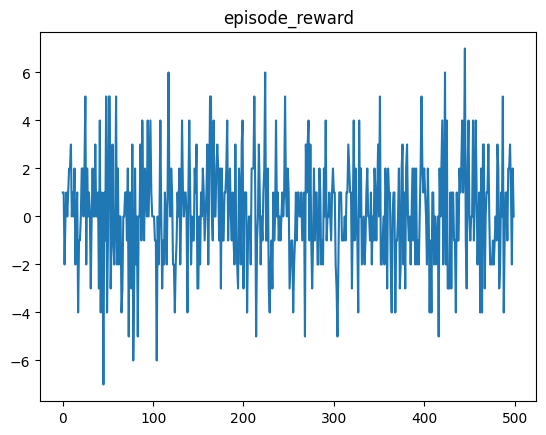

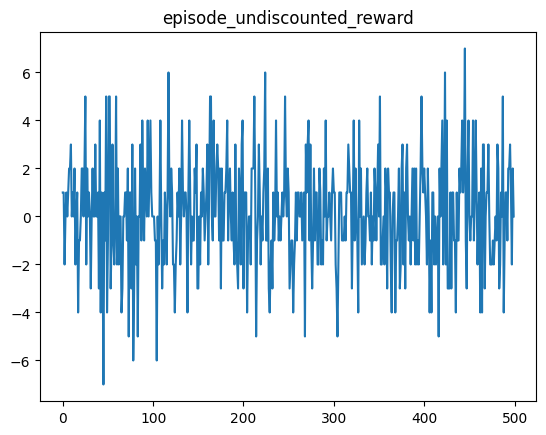

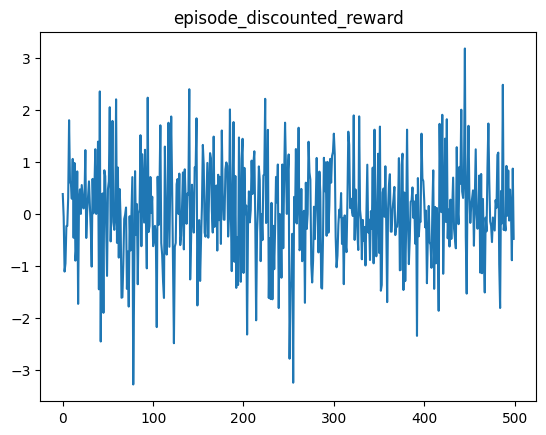

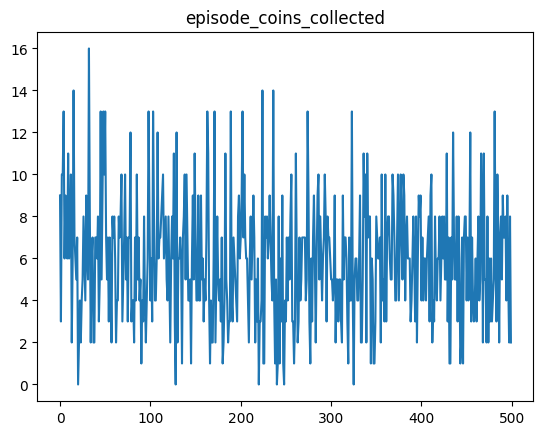

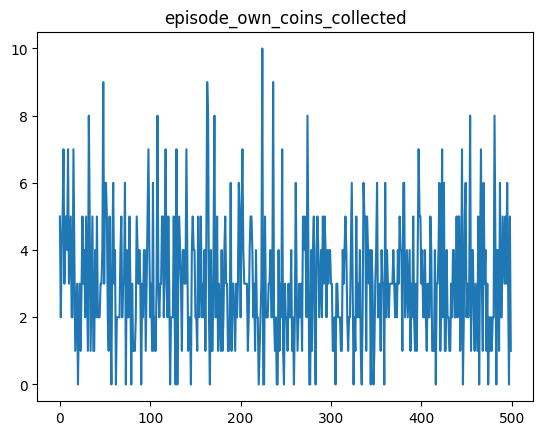

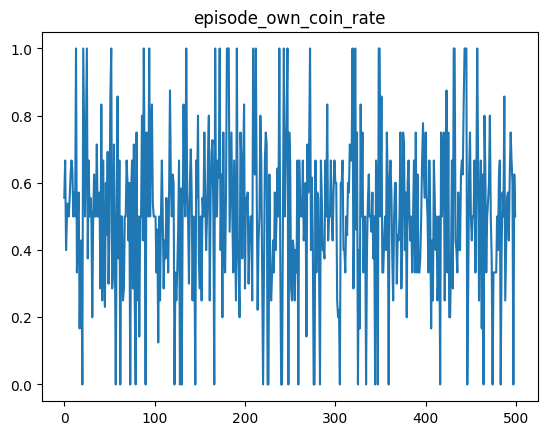

In [37]:
for k, data in metrics_history.items():
    plt.figure()
    plt.plot(data)
    plt.title(k)